In [3]:
import numpy as np
import matplotlib.pyplot as plt

Hurr_file = 'HURR_LOCS.npy'
Env_file = 'MONTHLY_ENV_PARAMS.npy'
Raw_data = 'hurricane_tracks_cleaned_land_ocean.csv'

In [4]:
Hurr_loc = np.load(Hurr_file)
print('shape：', Hurr_loc.shape)

shape： (528, 90, 180)


In [5]:
Env_data = np.load(Env_file)
print('shape：', Env_data.shape)

shape： (528, 90, 180, 19)


In [16]:
import pandas as pd

assert Env_data.ndim == 4 and Env_data.shape[-1] == 19, "数据维度不符合 (T, H, W, C) = (528, 90, 180, 19)"

stats = []
for i in range(Env_data.shape[-1]):
    channel_data = Env_data[..., i]
    stats.append({
        'Channel': i,
        'Min': np.min(channel_data),
        'Max': np.max(channel_data),
        'Mean': np.mean(channel_data),
        'Std': np.std(channel_data),
        'NaN Count': np.isnan(channel_data).sum(),
        'Inf Count': np.isinf(channel_data).sum()
    })


In [17]:
df = pd.DataFrame(stats)
print(df)

    Channel           Min           Max          Mean           Std  \
0         0  0.000000e+00      0.843394  6.834765e-02  1.078415e-01   
1         1 -2.033163e+03   2895.466095  1.137211e+03  4.606782e+02   
2         2 -3.963938e-06      0.000058  1.135685e-06  2.793299e-06   
3         3  6.286230e+00    114.749717  7.989578e+01  1.293401e+01   
4         4  2.356082e+02    316.238198  2.818969e+02  1.610598e+01   
5         5 -3.641275e-01      2.245198  1.653742e-02  7.661606e-02   
6         6  0.000000e+00      0.832097  1.270628e-01  8.921910e-02   
7         7  1.066777e+04  16141.473840  1.418844e+04  8.896031e+02   
8         8 -1.668469e-06      0.000043  7.982761e-07  1.413783e-06   
9         9  4.822344e+00    110.290440  6.720720e+01  1.484443e+01   
10       10  2.413105e+02    305.101661  2.763919e+02  1.338115e+01   
11       11 -1.380947e+00      2.099761  5.632108e-03  7.010106e-02   
12       12  0.000000e+00      0.646768  9.473072e-02  7.748505e-02   
13    

In [19]:
# Storage for stats
means = []
stds = []

# Clone to avoid modifying original
env_norm = env_data.copy()

# Per-channel normalization
for i in range(env_data.shape[-1]):
    ch = env_norm[..., i]

    # Replace invalid values with finite fallback (mean)
    ch = np.nan_to_num(ch, nan=np.nanmean(ch), posinf=0.0, neginf=0.0)

    mean = np.mean(ch)
    std = np.std(ch)
    if std < 1e-6 or not np.isfinite(std):
        print(f"⚠️ Warning: Channel {i} has near-zero or invalid std = {std:.4e}. Forcing std = 1.")
        std = 1.0

    # Apply normalization
    env_norm[..., i] = (ch - mean) / std

    # Record stats used
    means.append(mean)
    stds.append(std)

# Save normalized data and stats
np.save('env_data_normalized.npy', env_norm)
stats_df = pd.DataFrame({'Channel': list(range(env_data.shape[-1])), 'Mean': means, 'Std': stds})
stats_df.to_csv('env_channel_norm_stats.csv', index=False)
print("✅ Saved normalized data and stats.")

# ================== Validation ==================
print("\n🔍 Validation of standardized data:")
for i in range(env_norm.shape[-1]):
    ch = env_norm[..., i]
    ch_mean = np.mean(ch)
    ch_std = np.std(ch)
    ch_nan = np.isnan(ch).sum()
    ch_inf = np.isinf(ch).sum()
    ch_zero = np.sum(ch == 0)
    print(f"Channel {i:2d}: mean = {ch_mean:.4f}, std = {ch_std:.4f}, NaN = {ch_nan}, Inf = {ch_inf}, ZeroCount = {ch_zero}")

# Final check
assert np.isfinite(env_norm).all(), "❌ Detected NaN or Inf in normalized data!"
print("✅ All channels passed numerical integrity check.")

⚠️ Warning: Channel 14 has near-zero or invalid std = 2.5942e-07. Forcing std = 1.
✅ Saved normalized data and stats.

🔍 Validation of standardized data:
Channel  0: mean = 0.0000, std = 1.0000, NaN = 0, Inf = 0, ZeroCount = 0
Channel  1: mean = -0.0000, std = 1.0000, NaN = 0, Inf = 0, ZeroCount = 0
Channel  2: mean = 0.0000, std = 1.0000, NaN = 0, Inf = 0, ZeroCount = 0
Channel  3: mean = -0.0000, std = 1.0000, NaN = 0, Inf = 0, ZeroCount = 0
Channel  4: mean = 0.0000, std = 1.0000, NaN = 0, Inf = 0, ZeroCount = 0
Channel  5: mean = 0.0000, std = 1.0000, NaN = 0, Inf = 0, ZeroCount = 0
Channel  6: mean = 0.0000, std = 1.0000, NaN = 0, Inf = 0, ZeroCount = 0
Channel  7: mean = -0.0000, std = 1.0000, NaN = 0, Inf = 0, ZeroCount = 0
Channel  8: mean = 0.0000, std = 1.0000, NaN = 0, Inf = 0, ZeroCount = 0
Channel  9: mean = 0.0000, std = 1.0000, NaN = 0, Inf = 0, ZeroCount = 0
Channel 10: mean = -0.0000, std = 1.0000, NaN = 0, Inf = 0, ZeroCount = 0
Channel 11: mean = 0.0000, std = 1.0000

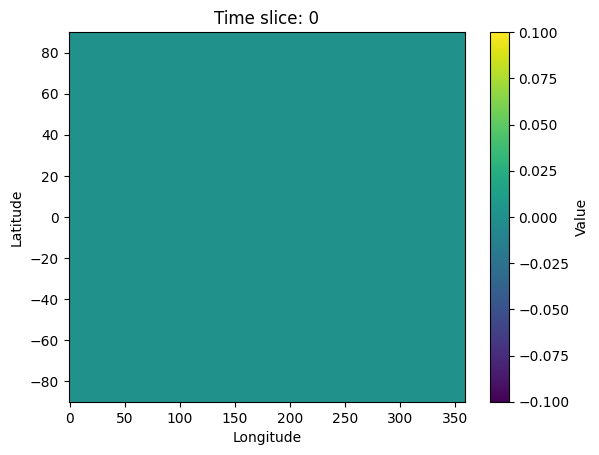

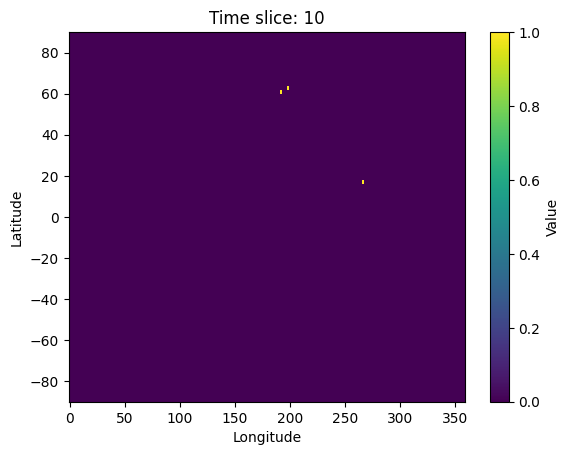

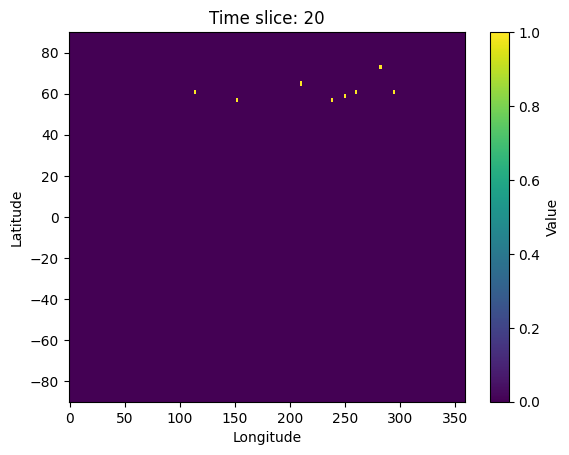

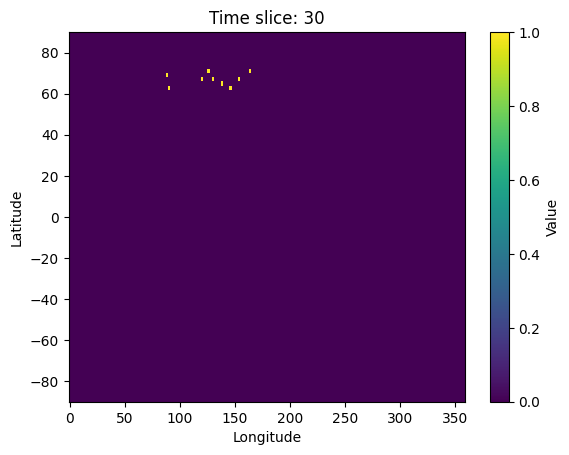

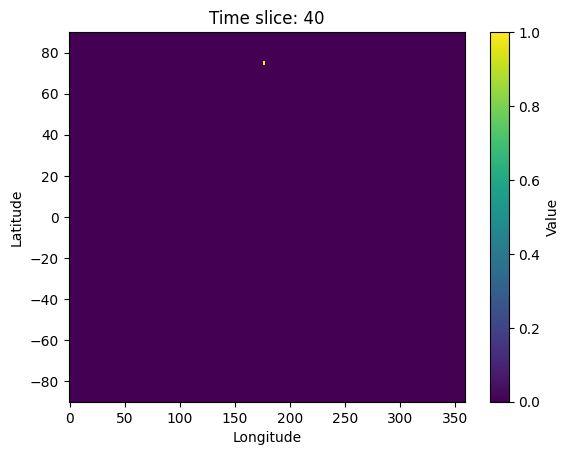

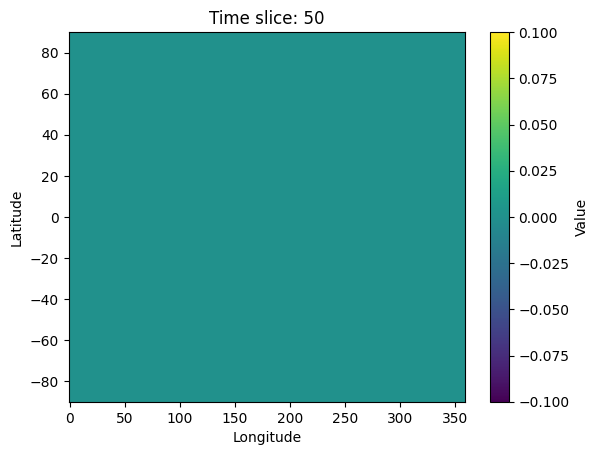

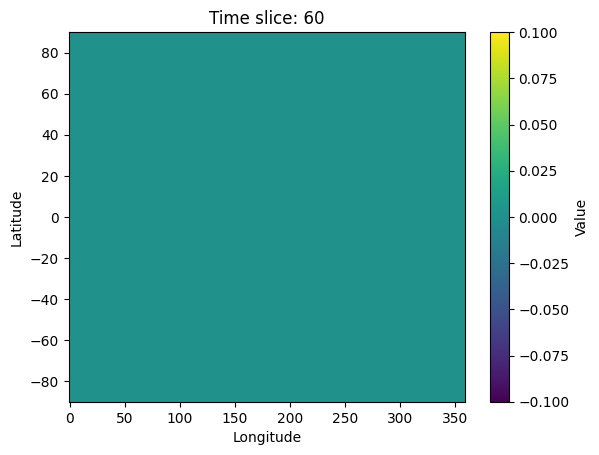

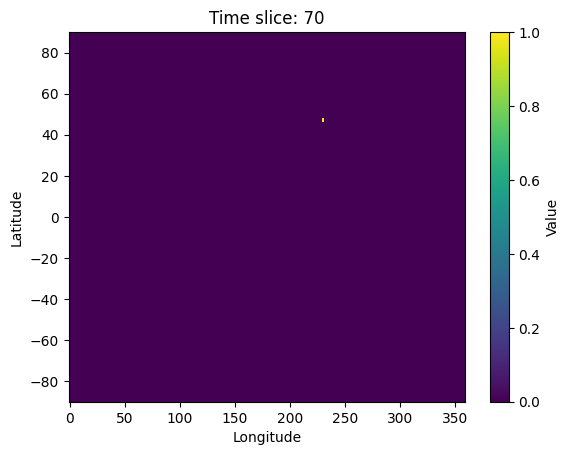

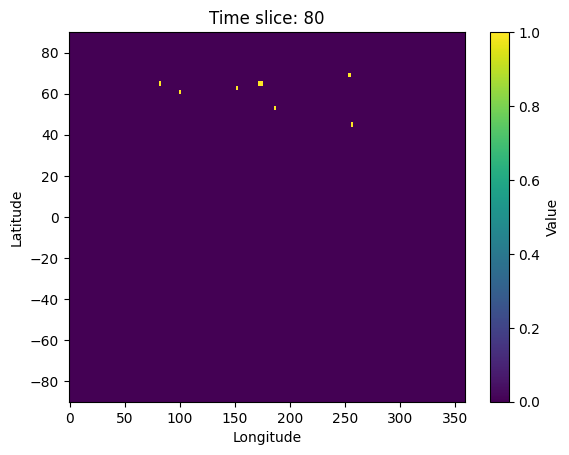

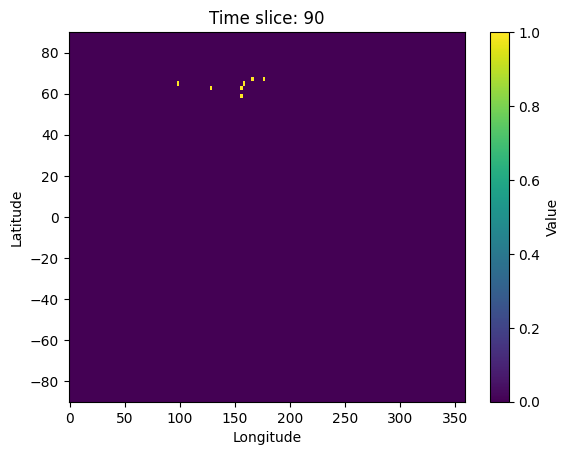

In [6]:
time_slice = 10
start = 0
end = 100
# Load the hurricane data
data = np.load(Hurr_file)

lats = np.linspace(-89, 89, data.shape[1])
lons = np.linspace(0, 358, data.shape[2])
lon2d, lat2d = np.meshgrid(lons, lats)

# construct latitude/longitude grid (2°×2° resolution)
lats = np.linspace(-89, 89, data.shape[1])
lons = np.linspace(0, 358, data.shape[2])
lon2d, lat2d = np.meshgrid(lons, lats)

# plot every 10th time slice
for idx in range(start,end,time_slice):
    plt.figure()
    plt.pcolormesh(lon2d, lat2d, data[idx], shading='auto')
    plt.title(f"Time slice: {idx}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label="Value")
    plt.show()

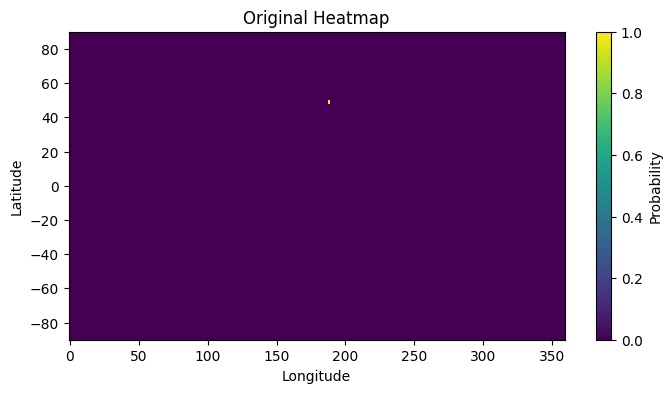

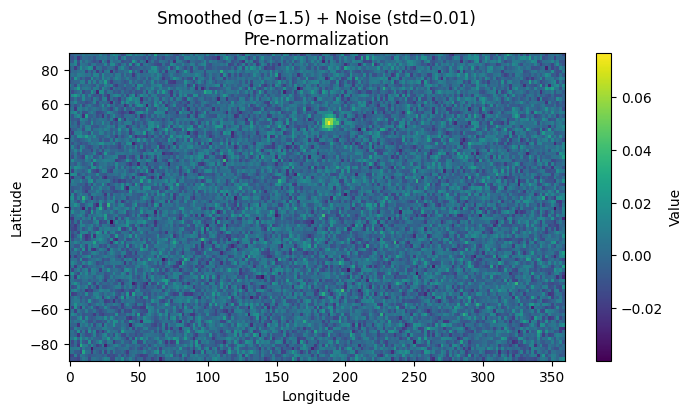

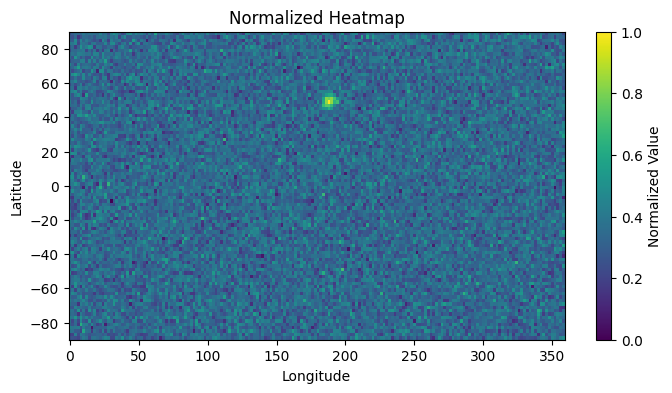

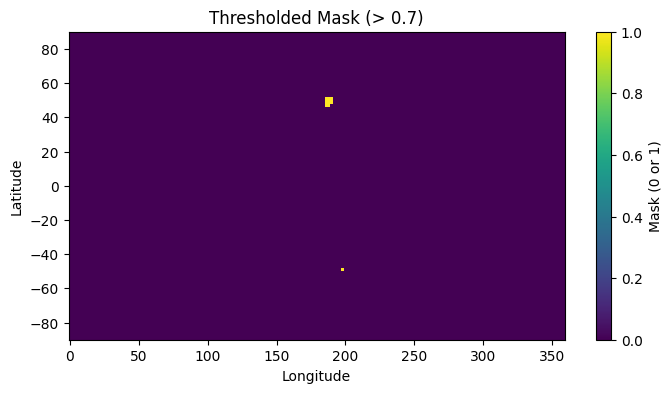

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# load data
input    = np.load(Env_file)      # shape: (528, 90, 180, 19)
labels   = np.load(Hurr_file)     # shape: (528, 90, 180)

# preprocessing parameters
sigma     = 1.5    # Gaussian smoothing σ (in grid units)
noise_std = 0.01   # Gaussian noise standard deviation

# construct latitude/longitude grid (2°×2°)
lats, lons = np.linspace(-89, 89, labels.shape[1]), np.linspace(0, 358, labels.shape[2])
lon2d, lat2d = np.meshgrid(lons, lats)

# choose a time slice for demonstration
idx = 100
orig = labels[idx]

# apply Gaussian smoothing
smoothed = gaussian_filter(orig, sigma=sigma)

# add Gaussian noise
noise     = np.random.normal(loc=0.0, scale=noise_std, size=orig.shape)
processed = smoothed + noise

# renormalize to [0, 1]
p_min, p_max       = processed.min(), processed.max()
processed_norm     = (processed - p_min) / (p_max - p_min)

# threshold to create a binary mask
threshold = 0.7
mask      = processed_norm > threshold

# visualize original heatmap
plt.figure(figsize=(8, 4))
plt.pcolormesh(lon2d, lat2d, orig, shading='auto')
plt.title("Original Heatmap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Probability")
plt.show()

# visualize smoothed + noisy (pre-normalization)
plt.figure(figsize=(8, 4))
plt.pcolormesh(lon2d, lat2d, processed, shading='auto')
plt.title(f"Smoothed (σ={sigma}) + Noise (std={noise_std})\nPre-normalization")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Value")
plt.show()

# visualize normalized heatmap
plt.figure(figsize=(8, 4))
plt.pcolormesh(lon2d, lat2d, processed_norm, shading='auto')
plt.title("Normalized Heatmap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Normalized Value")
plt.show()

# visualize thresholded mask
plt.figure(figsize=(8, 4))
plt.pcolormesh(lon2d, lat2d, mask, shading='auto')
plt.title(f"Thresholded Mask (> {threshold})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Mask (0 or 1)")
plt.show()


In [8]:
# convert labels to binary classification
from collections import Counter
N, H, W = labels.shape
labels_cls = (labels.reshape(N, -1).sum(axis=1) > 0).astype(np.int64)  # shape (N,)
print(labels_cls.shape)
print(labels_cls)

(528,)
[0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0
 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0
 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0
 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1
 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1
 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1
 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1
 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1 1
 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1
 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0
 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0
 0 0 1 1 1 1 1 1 1

In [9]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [10]:
class HurricaneDataset(Dataset):
    def __init__(self, env_data, labels_raw, T=24):
        """
        env_data: numpy array (N, H, W, C)
        labels_raw: numpy array (N, H, W)
        T: number of input months
        """
        self.X = torch.from_numpy(env_data).float()   # (N, H, W, C)
        bin_lbl = (labels_raw.reshape(len(labels_raw), -1).sum(1) > 0).astype(np.int64)
        self.y = torch.from_numpy(bin_lbl)           # (N,)
        self.T = T

    def __len__(self):
        return len(self.X) - self.T

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.T]               # (T, H, W, C)
        y_lbl = self.y[idx+self.T]                   # scalar 0/1
        return x_seq, y_lbl

In [11]:
import torch
import torch.nn as nn
from torchinfo import summary

class HurrClassifier(nn.Module):
    """
    Improved hurricane occurrence classifier with spatial downsampling:
    1) Multi‐scale 3D conv for spatio‐temporal fusion
    2) 3D patch embedding to downsample spatial dims by 4×4
    3) Explicit time & downsampled space positional encodings
    4) Spatio‐temporal Transformer encoder
    5) Classification head
    """
    def __init__(self, in_ch, T, D=64, N=4, M=2, H=128):
        super().__init__()
        self.D = D
        # 1) Multi‐scale 3D convolutions
        self.ms1  = nn.Conv3d(in_ch,   D, kernel_size=(1,3,3), padding=(0,1,1))
        self.ms2  = nn.Conv3d(in_ch,   D, kernel_size=(1,5,5), padding=(0,2,2))
        self.ms3  = nn.Conv3d(in_ch,   D, kernel_size=(3,3,3), padding=(1,1,1))
        self.fuse = nn.Conv3d(3*D,     D, kernel_size=1)
        # 2) 3D patch embedding: downsample H×W by 4×4
        self.patch3d = nn.Conv3d(D, D,
                                 kernel_size=(1,4,4),
                                 stride=(1,4,4),
                                 padding=(0,1,1))
        # compute downsampled spatial dims
        Hd, Wd = (90 + 3)//4, (180 + 3)//4  # ceil division
        # 3) Positional encodings for T×Hd×Wd tokens
        self.temporal_pe = nn.Parameter(torch.randn(1, T, 1, 1, D))
        self.spatial_pe  = nn.Parameter(torch.randn(1, 1, Hd, Wd, D))
        # 4) LayerNorm before Transformer
        self.norm = nn.LayerNorm(D)
        # 5) Spatio‐temporal Transformer
        enc_layer = nn.TransformerEncoderLayer(d_model=D,
                                               nhead=N,
                                               batch_first=True)
        self.trans = nn.TransformerEncoder(enc_layer, num_layers=M)
        # 6) Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(D),
            nn.Linear(D, H), nn.GELU(),
            nn.LayerNorm(H),
            nn.Linear(H, 2)
        )

    def forward(self, x):
        # x: (B, T, H, W, C)
        B, T_, H_, W_, C_ = x.shape
        # to (B, C, T, H, W)
        x = x.permute(0,4,1,2,3)
        # multi‐scale convs → (B, D, T, H, W)
        f1 = self.ms1(x); f2 = self.ms2(x); f3 = self.ms3(x)
        x  = self.fuse(torch.cat([f1, f2, f3], dim=1))
        # 3D patch embedding → (B, D, T, Hd, Wd)
        x  = self.patch3d(x)
        # back to (B, T, Hd, Wd, D)
        x  = x.permute(0,2,3,4,1)
        # add positional encodings (in‐place)
        x.add_(self.temporal_pe).add_(self.spatial_pe)
        # normalize
        x = self.norm(x)
        # flatten to tokens (B, T*Hd*Wd, D)
        B2, T2, Hd2, Wd2, D2 = x.shape
        tokens = x.reshape(B2, T2*Hd2*Wd2, D2)
        # transformer
        out = self.trans(tokens)
        # global average pool → (B, D)
        agg = out.mean(dim=1)
        # classification logits → (B, 2)
        return self.classifier(agg)
    

# hyperparams
T = 24     # input months
C = 19     # input channels
model = HurrClassifier(in_ch=C, T=T, D=64, N=4, M=2, H=128)
summary(model, input_size=(1, T, 90, 180, C), depth=4)

Layer (type:depth-idx)                        Output Shape              Param #
HurrClassifier                                [1, 2]                    67,776
├─Conv3d: 1-1                                 [1, 64, 24, 90, 180]      11,008
├─Conv3d: 1-2                                 [1, 64, 24, 90, 180]      30,464
├─Conv3d: 1-3                                 [1, 64, 24, 90, 180]      32,896
├─Conv3d: 1-4                                 [1, 64, 24, 90, 180]      12,352
├─Conv3d: 1-5                                 [1, 64, 24, 23, 45]       65,600
├─LayerNorm: 1-6                              [1, 24, 23, 45, 64]       128
├─TransformerEncoder: 1-7                     [1, 24840, 64]            --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 24840, 64]            281,152
│    │    └─TransformerEncoderLayer: 3-2      [1, 24840, 64]            281,152
├─Sequential: 1-8                             [1, 2]        

In [12]:
import torch
env_data   = np.load(Env_file)   # shape (528, 90, 180, 19)
labels_raw = np.load(Hurr_file)  # shape (528, 90, 180)


print("CUDA available:", torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

model = HurrClassifier(in_ch=C, T=T, D=64, N=4, M=2, H=128).to(device)

print("Model parameters on GPU:", next(model.parameters()).is_cuda)

CUDA available: True
Using device: cuda
Model parameters on GPU: True


In [14]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

# --- Hyperparameters (single‐letter) ---
T    = 23        # sliding window length
B    = 8         # physical batch size (we’ll accumulate to effective 16)
ACC  = 4         # gradient accumulation steps
L    = 1e-3      # learning rate
E    = 10        # epochs
S    = 0.8       # train split fraction
V    = 0.1       # val split fraction

# --- Data loading ---
X = np.load(Env_file)    # (N,90,180,19)
Y = np.load(Hurr_file)   # (N,90,180)

# --- Dataset & splits ---
full_ds = HurricaneDataset(X, Y, T)
n = len(full_ds)
n_train = int(S * n)
n_val   = int(V * n)
n_test  = n - n_train - n_val

train_ds, val_ds, test_ds = random_split(
    full_ds, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)
train_loader = DataLoader(train_ds, batch_size=B, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=B, shuffle=False, num_workers=0)

# --- Model, optimizer, loss, scaler ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = HurrClassifier(in_ch=X.shape[-1], T=T, D=64, N=4, M=2, H=128).to(device)
opt    = torch.optim.AdamW(model.parameters(), lr=L)
crit   = nn.CrossEntropyLoss()
scaler = GradScaler()

# Optionally reduce fragmentation
torch.backends.cuda.max_split_size_mb = 128

# --- Training & Validation Loop with mixed precision + accumulation ---
for epoch in range(1, E+1):
    model.train()
    running_loss = 0.0
    opt.zero_grad()

    train_iter = tqdm(train_loader, desc=f"Epoch {epoch}/{E} [Train]")
    for i, (x_batch, y_batch) in enumerate(train_iter):
        x_batch = x_batch.to(device)          # (B,T,90,180,19)
        y_batch = y_batch.to(device).long()   # (B,)

        with autocast():
            logits = model(x_batch)                   # (B,2)
            loss   = crit(logits, y_batch)
            loss   = loss / ACC                       # scale down for accumulation

        scaler.scale(loss).backward()

        if (i+1) % ACC == 0:
            scaler.step(opt)
            scaler.update()
            opt.zero_grad()

        running_loss += loss.item() * ACC * x_batch.size(0)
        train_iter.set_postfix(batch_loss=loss.item()*ACC)

    train_loss = running_loss / n_train

    # --- Validation (no accumulation) ---
    model.eval()
    correct = 0
    with torch.no_grad(), autocast():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device).long()
            logits = model(x_val)                     # (B,2)
            preds  = torch.argmax(logits, dim=-1)     # (B,)
            correct += (preds == y_val).sum().item()

    val_acc = correct / n_val
    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Acc = {val_acc:.4f}")

KeyboardInterrupt: 